# Recursive Learning Model
Including:
- Smoothing data with splines

## 1. Initial Set up

In [1]:
import time
import numpy as np
from scipy.interpolate import make_splrep
from scipy.io import loadmat

In [2]:
import nengo
import numpy as np
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

First we import the raw data from MT_S2

In [3]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S2"

# Datapath to get the raw data file (Stored in DataExtraction)
datafile_path = "./../../Data Extraction/Extracted Data/MT_S1_raw.csv"      # r"..\\..\\Data Extraction\\Extracted Data\\"+monkey+"_raw.csv"

inp = loadmat('/Users/anny/Code/Wat_ai/BCI-Signal-Decoding/Data Extraction/matlab-files/source_data/raw/MT_S2_raw.mat')

# Apparently Scipy allows us to pull from mat files??? Crazy
# Albeit the notation is horrific
t = inp['cont']['t'][0][0][:,0]
x_pos = inp['cont']['pos'][0][0][:,0]
y_pos = inp['cont']['pos'][0][0][:,1]
x_acl = inp['cont']['acc'][0][0][:,0]

df = pd.read_csv(datafile_path)

headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
print(headers)

# getting the activity matrix
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]

# # velocity data
# velocity_matrix = df[["x_velocity", "y_velocity"]]
# # acceleration data
# acceleration_matrix = df[["x_acceleration", "y_acceleration"]]
# # time stamp 
t = df["Timestamp"]
t = t.transpose().to_numpy()
x_pos = inp['cont']['pos'][0][0][:,0]
y_pos = inp['cont']['pos'][0][0][:,1]
x_acl = inp['cont']['acc'][0][0][:,0]

# transpose the data

activity_matrix_t = activity_matrix.transpose().to_numpy()
# velocity_matrix_t = velocity_matrix.transpose().to_numpy()
# acceleration_matrix_t = acceleration_matrix.transpose().to_numpy()


['Unnamed: 0', 'Timestamp', 'Neuron1', 'Neuron2', 'Neuron3', 'Neuron4', 'Neuron5', 'Neuron6', 'Neuron7', 'Neuron8', 'Neuron9', 'Neuron10', 'Neuron11', 'Neuron12', 'Neuron13', 'Neuron14', 'Neuron15', 'Neuron16', 'Neuron17', 'Neuron18', 'Neuron19', 'Neuron20', 'Neuron21', 'Neuron22', 'Neuron23', 'Neuron24', 'Neuron25', 'Neuron26', 'Neuron27', 'Neuron28', 'Neuron29', 'Neuron30', 'Neuron31', 'Neuron32', 'Neuron33', 'Neuron34', 'Neuron35', 'Neuron36', 'Neuron37', 'Neuron38', 'Neuron39', 'Neuron40', 'Neuron41', 'Neuron42', 'Neuron43', 'Neuron44', 'Neuron45', 'Neuron46', 'Neuron47', 'Neuron48', 'Neuron49', 'x_velocity', 'y_velocity', 'x_acceleration', 'y_acceleration']


Since the kinematic data is collected from a digital sensor, position can only be represented as a finite number of bits. This means that if we try to take the derivatives of the data to represent velocities/accelerations, we won't get a continuous result. 

Thus, let's try to smooth out our data using splines!

In [9]:
running_time = 19 # How long the model should run for

In [5]:
len_t = 20000


# Time length in milliseconds
start = time.time()
x_SPL = make_splrep(t[:len_t], x_pos[:len_t], s=0.1, k=4)
end = time.time()
print("X time: ", end - start)


start = time.time()
y_SPL = make_splrep(t[:len_t], y_pos[:len_t], s=0.1, k=4)
end = time.time()
print("Y time: ", end - start)

X time:  14.579333066940308
Y time:  24.300602912902832


## 2. Building the model

Setting the model parameters

In [10]:
d1_x = x_SPL.derivative(1) # X_Velocity
d2_x = d1_x.derivative(1) # X_Acceleration

d1_y = y_SPL.derivative(1) # Y_Velocity
d2_y = d1_y.derivative(1) # Y_Acceleration

acceleration_matrix_t = [d2_x(t[:len_t])/np.max(np.abs(d2_x(t[:len_t]))), 
                         d2_y(t[:len_t])/np.max(np.abs(d2_y(t[:len_t])))]

spikes = activity_matrix_t
scalar = np.max(acceleration_matrix_t)
target_out = acceleration_matrix_t/scalar 

# Model Information
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Model Parameters
n_ensemble_neurons = 3000
ensemble_radius = 1     # ? Represents the range of values for the neurons?
ensemble_synapse = 0.025
probe_synapse = 0.01

training_time = 0.8*running_time # WHen does the model stop learning


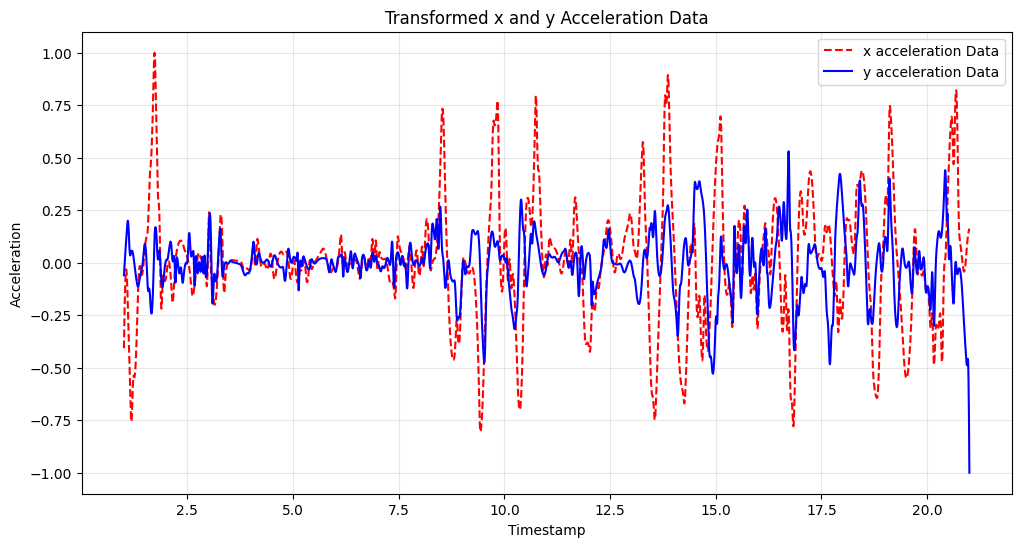

In [11]:
# Visualizing the kinematic data
# Plot the data
plt.figure(figsize=(12, 6))

# Plot original data
plt.plot(t[:len_t], acceleration_matrix_t[0], label="x acceleration Data", color='red', linestyle='--')

# Plot clipped data
plt.plot(t[:len_t], acceleration_matrix_t[1], label="y acceleration Data", color='blue', linestyle='-')


# Add labels, legend, title
plt.xlabel("Timestamp")
plt.ylabel("Acceleration")
plt.title("Transformed x and y Acceleration Data")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)

# Show the plot
plt.show()

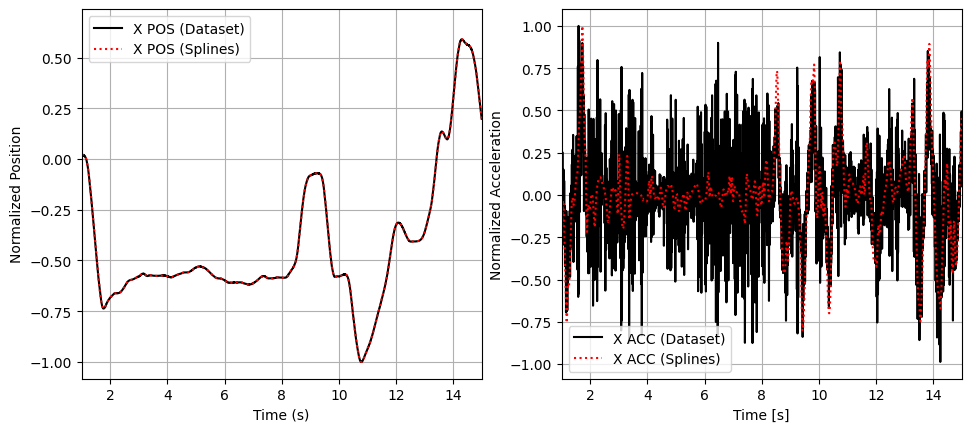

In [12]:
# Visualize Position
fig, (pl1, pl2) = plt.subplots(1, 2)
fig.subplots_adjust(right=1.5)
pl1.plot(t[:len_t], x_pos[:len_t]/np.max(np.abs(x_pos[:len_t])), "k", label="X POS (Dataset)")
pl1.plot(t[:len_t], x_SPL(t[:len_t])/np.max(np.abs(x_SPL(t[:len_t]))), "r:", label="X POS (Splines)")
pl1.set_xlim((1,15))
pl1.set_xlabel("Time (s)")
pl1.set_ylabel("Normalized Position")
pl1.legend()
pl1.grid()

# Visualize acceleration
pl2.plot(t[:len_t], x_acl[:len_t]/np.max(np.abs(x_acl[:len_t])), "k", label="X ACC (Dataset)")
pl2.plot(t[:len_t], d2_x(t[:len_t])/np.max(np.abs(d2_x(t[:len_t]))), "r:", label="X ACC (Splines)")
pl2.set_xlim(1,15)
pl2.set_ylabel("Normalized Acceleration")
pl2.set_xlabel("Time [s]")
pl2.legend()
pl2.grid()

Building the nengo network

In [13]:
with nengo.Network() as model:
    in_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])
    
    target_node = nengo.Node(lambda t: target_out[:,int(t / dt) - 1]) # expected kinematic output
    inhib_node = nengo.Node(output=lambda t: t >= training_time)

    rep_ens = nengo.Ensemble(n_ensemble_neurons, n_neurons, ensemble_radius)
    out_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)
    err_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)

    in_rep_con = nengo.Connection(in_node, rep_ens, ensemble_synapse) # Acts as a low-pass for the spike input
    rep_out_con = nengo.Connection(rep_ens, out_ens, function=lambda x: [0, 0], learning_rule_type=nengo.PES(learning_rate=2e-4))
    out_err_con = nengo.Connection(out_ens, err_ens)
    tar_err_con = nengo.Connection(target_node, err_ens, transform=-1)
    err_lrn_con = nengo.Connection(err_ens, rep_out_con.learning_rule) # Connects error ensemble value to learning rule -- analogous to how backprop uses error to follow stochastic gradient in training
    inhib_lrn_con = nengo.Connection(inhib_node, err_ens.neurons, transform=-20 * np.ones((err_ens.n_neurons, 1))) # Inhibit error ensemble once training is done to prevent weight changes after training_time

    p_out = nengo.Probe(out_ens, synapse=probe_synapse)
    p_err = nengo.Probe(err_ens, synapse=probe_synapse)




## 3. Visualizing results


In [14]:
save_file = "./melm_params"
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

Build finished in 0:00:06.                                                      
Simulation finished in 0:00:14.                                                 


In [ ]:
# Save the model (lol this doesn't work)
# with open('simulation.pkl', 'wb') as file:
#     pickle.dump(sim.data, file)


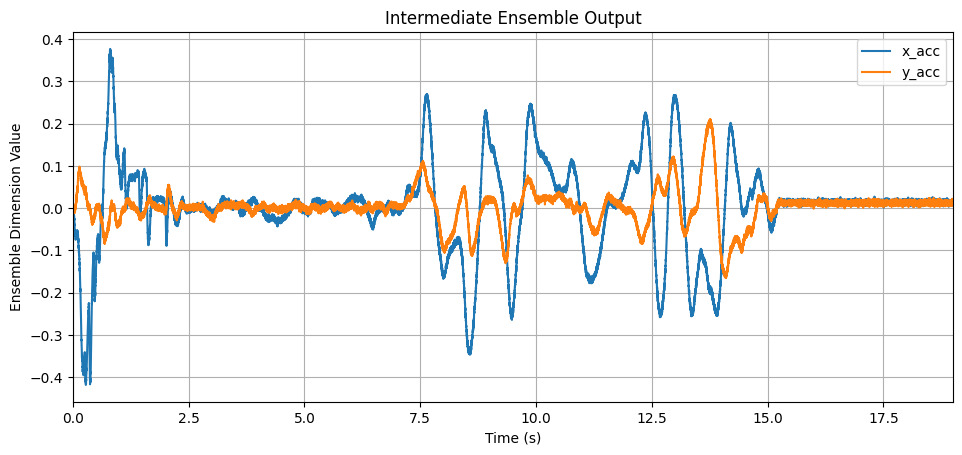

In [15]:
# For the outputs
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_out])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

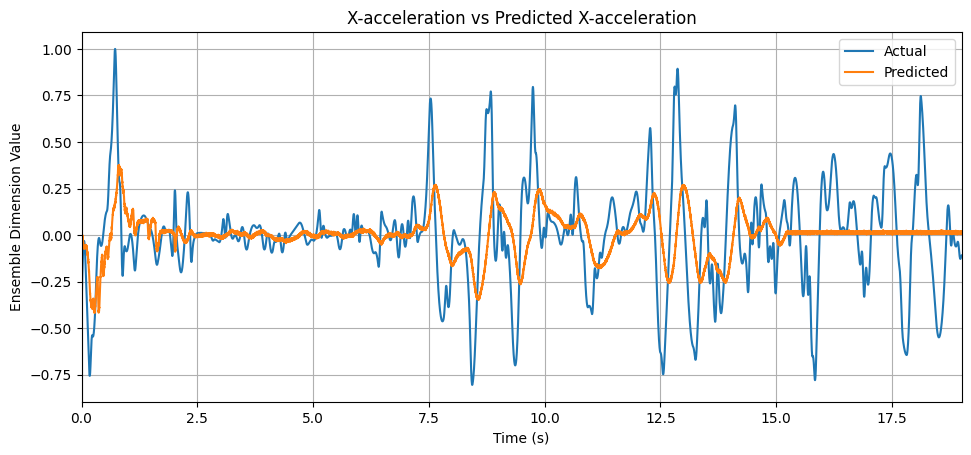

In [16]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[0, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

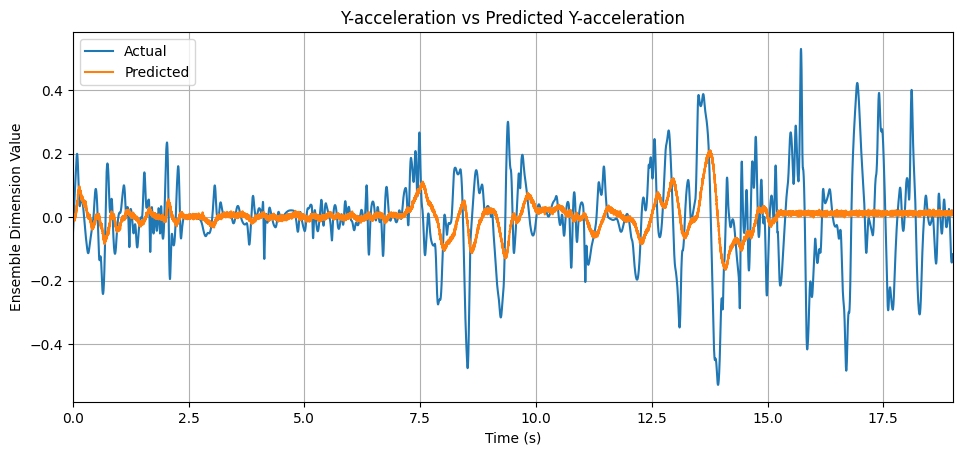

In [17]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

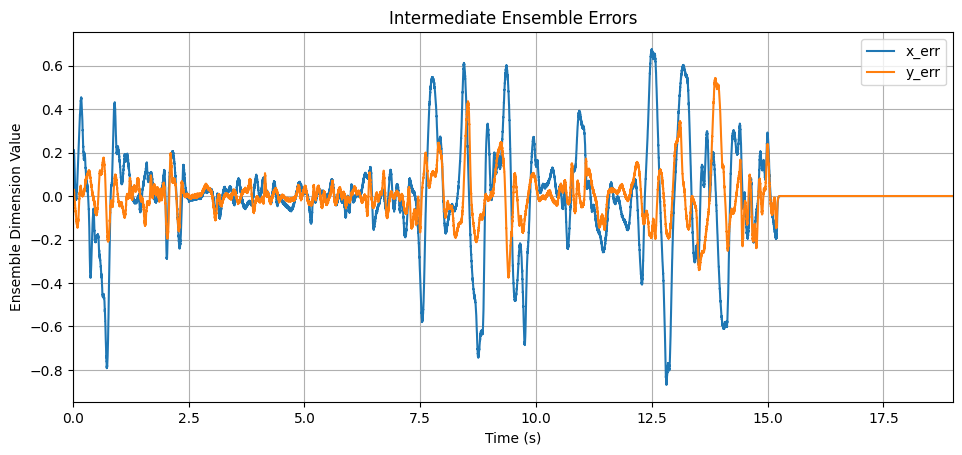

In [18]:
# For the errors
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_err])
pl.set_title("Intermediate Ensemble Errors")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_err", "y_err"])
pl.grid()

## 4. Evaluation

In [19]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

In [20]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(target_out[0, 0:len(sim.trange())], sim.data[p_out][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(target_out[1, 0:len(sim.trange())], sim.data[p_out][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.1819049608312321
Root Mean_Squared Error: 0.26295077147510354

Y-Acceleration Error
Mean Absolute Error: 0.09152055212909987
Root Mean_Squared Error: 0.13467107117499058

